In [1]:
# !pip install snscrape
# !pip install contractions
# !pip install newspaper3k
# !pip install newsapi-python
# !pip install tqdm
# !pip install transformers
# !pip install nltk

# Importing necessary packages

In [2]:
# Data Manipulation and Analysis Libraries
import pandas as pd
import numpy as np
from math import sqrt

# Data Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Preprocessing and Scaling
from sklearn.preprocessing import MinMaxScaler

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.regularizers import l2

# Evaluation Metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score

# Natural Language Processing
import string
import contractions
from newspaper import Article
from transformers import pipeline
from tqdm import tqdm
from nltk.sentiment import SentimentIntensityAnalyzer

# Mathematical Operations
import math

# Date and time
from datetime import datetime
import pytz

print("Setup Complete")


Setup Complete


# Loading the data

In [3]:
df = pd.read_csv("stock_tweets.csv")

# Data Cleaning

In [4]:
df.head()

,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


In [5]:
df[df.duplicated(subset="Tweet", keep=False)]

,Date,Tweet,Stock Name,Company Name
7,2022-09-29 22:23:54+00:00,$NIO just because I'm down money doesn't mean ...,TSLA,"Tesla, Inc."
25,2022-09-29 18:46:07+00:00,Today they're shooting the generals.\n$AAPL $T...,TSLA,"Tesla, Inc."
36,2022-09-29 17:40:44+00:00,$TSLA along a few others the only interesting ...,TSLA,"Tesla, Inc."
56,2022-09-29 15:10:30+00:00,Top 10 $QQQ Holdings \n\nAnd Credit Rating\n\n...,TSLA,"Tesla, Inc."
62,2022-09-29 14:50:40+00:00,The last two remaining blocks in the market ar...,TSLA,"Tesla, Inc."
...,...,...,...,...
80775,2021-10-17 13:51:03+00:00,Weekly Watchlist 🎯 \n\n$BABA 175c &gt; 170 | 1...,XPEV,XPeng Inc.
80778,2021-10-15 21:13:27+00:00,Weekly Recap:\nDividend Received:\n$AGNC - $40...,XPEV,XPeng Inc.
80782,2021-10-14 23:24:45+00:00,Are Cathie Wood's GROWTH Stocks Ready to Soar?...,XPEV,XPeng Inc.
80786,2021-10-11 03:51:36+00:00,"NIO reached 100,000 vehicle rolled off the pro...",XPEV,XPeng Inc.


##  Arranging date in dd-mm-yy format

In [6]:
# Define a function to clean and format date strings
def clean_and_format_date(date_string):
    date_obj = datetime.strptime(date_string, '%Y-%m-%d %H:%M:%S%z')
    formatted_date = date_obj.astimezone(pytz.utc).strftime('%Y-%m-%d')
    return formatted_date


# Apply the clean_and_format_date function to all cells in the DataFrame
df['Date'] = df["Date"].apply(clean_and_format_date)

In [7]:
df.head()

,Date,Tweet,Stock Name,Company Name
0,2022-09-29,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


## Plotting the Number of Tweets per month

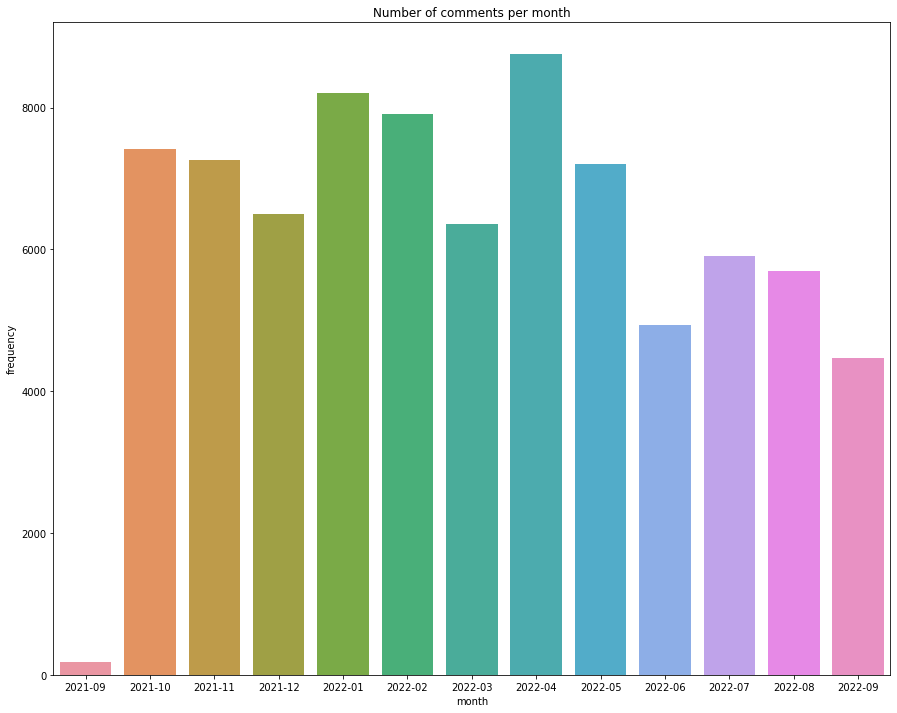

In [8]:
df["month"] = df["Date"].apply(lambda x: x[:-3])

plt.figure(figsize=(15,12))
plt.title("Number of comments per month")

tweets = df.groupby("month").size().reset_index(name = "frequency")
sns.barplot(x = tweets["month"], y = tweets["frequency"])
plt.show()

## Checking for any null Values

In [9]:
df.isnull().sum()

Date            0
Tweet           0
Stock Name      0
Company Name    0
month           0
dtype: int64

# Cleaning the Tweets

# 1. converting the description to lowercase

In [10]:
df["Tweet"] = df["Tweet"].str.lower()

In [11]:
df["Tweet"]

0        mainstream media has done an amazing job at br...
1        tesla delivery estimates are at around 364k fr...
2        3/ even if i include 63.0m unvested rsus as of...
3        @realdanodowd @wholemarsblog @tesla hahaha why...
4        @realdanodowd @tesla stop trying to kill kids,...
                               ...                        
80788    some of the fastest growing tech stocks on the...
80789    with earnings on the horizon, here is a quick ...
80790    our record delivery results are a testimony of...
80791    we delivered 10,412 smart evs in sep 2021, rea...
80792    why can xpeng p5 deliver outstanding performan...
Name: Tweet, Length: 80793, dtype: object

# 2. removing all the stop words

In [12]:
def translator(text):
    translator = str.maketrans("","", string.punctuation)
    return text.translate(translator)

In [13]:
df["Tweet"] = df["Tweet"].apply(translator)

In [14]:
df["Tweet"]

0        mainstream media has done an amazing job at br...
1        tesla delivery estimates are at around 364k fr...
2        3 even if i include 630m unvested rsus as of 6...
3        realdanodowd wholemarsblog tesla hahaha why ar...
4        realdanodowd tesla stop trying to kill kids yo...
                               ...                        
80788    some of the fastest growing tech stocks on the...
80789    with earnings on the horizon here is a quick s...
80790    our record delivery results are a testimony of...
80791    we delivered 10412 smart evs in sep 2021 reach...
80792    why can xpeng p5 deliver outstanding performan...
Name: Tweet, Length: 80793, dtype: object

# 3. removing any extra spaces 

In [15]:
df["Tweet"] = df["Tweet"].apply(lambda x : " ".join(x.split()))

# 4. removing contractions


In [16]:
df["Tweet"] = df["Tweet"].apply(lambda x : contractions.fix(x))

# Sentiment Analysis

#  1. Sentiment analysis using VADER sentiment scoring

In [17]:
# Run the polarity score on the entire dataset
sia = SentimentIntensityAnalyzer()
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)) :
    text = row[ "Tweet" ]
    res[i] = sia.polarity_scores(text)

100%|██████████| 80793/80793 [00:50<00:00, 1603.76it/s]


In [18]:

vaders = pd.DataFrame(res).T
vaders = vaders.rename(columns={"compound":"compound_vader","neu":"neu_vader",'pos': 'pos_vader', 'neg': 'neg_vader'})
vaders = vaders.reset_index()


In [19]:
# Add an "id" column with unique identifiers
df["index"] = range(1, len(df) + 1)

vaders = vaders.merge(df, on = "index")

In [20]:
vaders.head()

,index,neg_vader,neu_vader,pos_vader,compound_vader,Date,Tweet,Stock Name,Company Name,month
0,1,0.000,1.000,0.000,0.0000,2022-09-29,mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc.",2022-09
1,2,0.000,0.950,0.050,0.2960,2022-09-29,tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc.",2022-09
2,3,0.259,0.605,0.136,-0.7096,2022-09-29,3 even if i include 630m unvested rsus as of 6...,TSLA,"Tesla, Inc.",2022-09
3,4,0.526,0.474,0.000,-0.8750,2022-09-29,realdanodowd wholemarsblog tesla hahaha why ar...,TSLA,"Tesla, Inc.",2022-09
4,5,0.000,1.000,0.000,0.0000,2022-09-29,realdanodowd tesla stop trying to kill kids yo...,TSLA,"Tesla, Inc.",2022-09


## 2. Using the transformers pipelineCalculating the sentiment scores of the tweets


In [21]:
sentiment_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


In [22]:
x = []
for text in tqdm(df["Tweet"]):
    x.append(sentiment_pipeline(text))
df["sentiment_label"] = [item[0]["label"] for item in x]
df["sentiment_score"] = [item[0]["score"] for item in x]

100%|██████████| 80793/80793 [46:32<00:00, 28.93it/s]   


In [23]:
df.head()

,Date,Tweet,Stock Name,Company Name,month,index,sentiment_label,sentiment_score
0,2022-09-29,mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc.",2022-09,1,POSITIVE,0.557652
1,2022-09-29,tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc.",2022-09,2,NEGATIVE,0.994935
2,2022-09-29,3 even if i include 630m unvested rsus as of 6...,TSLA,"Tesla, Inc.",2022-09,3,NEGATIVE,0.997982
3,2022-09-29,realdanodowd wholemarsblog tesla hahaha why ar...,TSLA,"Tesla, Inc.",2022-09,4,NEGATIVE,0.998214
4,2022-09-29,realdanodowd tesla stop trying to kill kids yo...,TSLA,"Tesla, Inc.",2022-09,5,NEGATIVE,0.992412


# Grouping the tweets by date, and calculating the average Sentiment score per day

In [67]:
grouped_data = df.groupby('Date')
# Define a function to calculate weighted sentiment for each group (date)
def calculate_weighted_sentiment(group):
    # Use sentiment scores as weights for sentiment labels
    sentiment_labels = group['sentiment_label']
    sentiment_scores = group['sentiment_score']
    
    # Map sentiment labels to sentiment weights (e.g., POSITIVE=1, NEGATIVE=-1, NEUTRAL=0)
    sentiment_weights = sentiment_labels.map({'POSITIVE': 1, 'NEGATIVE': -1, 'NEUTRAL': 0})
    # Calculate the weighted sentiment score
    weighted_sentiment_score = (sentiment_weights * sentiment_scores).sum() / sentiment_weights.abs().sum()
    
    return weighted_sentiment_score




In [68]:
# Calculate the daily weighted sentiment score
daily_sentiment = grouped_data.apply(calculate_weighted_sentiment).reset_index()
daily_sentiment.columns = ['Date', 'WeightedSentimentScore']


In [26]:
daily_sentiment

,Date,WeightedSentimentScore
0,2021-09-30,-0.280744
1,2021-10-01,-0.455173
2,2021-10-02,-0.363565
3,2021-10-03,-0.272854
4,2021-10-04,-0.668217
...,...,...
360,2022-09-25,-0.650949
361,2022-09-26,-0.459932
362,2022-09-27,-0.603566
363,2022-09-28,-0.614348


In [27]:
df.head()

,Date,Tweet,Stock Name,Company Name,month,index,sentiment_label,sentiment_score
0,2022-09-29,mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc.",2022-09,1,POSITIVE,0.557652
1,2022-09-29,tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc.",2022-09,2,NEGATIVE,0.994935
2,2022-09-29,3 even if i include 630m unvested rsus as of 6...,TSLA,"Tesla, Inc.",2022-09,3,NEGATIVE,0.997982
3,2022-09-29,realdanodowd wholemarsblog tesla hahaha why ar...,TSLA,"Tesla, Inc.",2022-09,4,NEGATIVE,0.998214
4,2022-09-29,realdanodowd tesla stop trying to kill kids yo...,TSLA,"Tesla, Inc.",2022-09,5,NEGATIVE,0.992412


In [28]:
daily_sentiment.head(10)

,Date,WeightedSentimentScore
0,2021-09-30,-0.280744
1,2021-10-01,-0.455173
2,2021-10-02,-0.363565
3,2021-10-03,-0.272854
4,2021-10-04,-0.668217
5,2021-10-05,-0.535953
6,2021-10-06,-0.547492
7,2021-10-07,-0.457579
8,2021-10-08,-0.375475
9,2021-10-09,-0.489760


## Checking for any positive comments

In [29]:
daily_sentiment[daily_sentiment['WeightedSentimentScore'] > 0]

,Date,WeightedSentimentScore


### If all the tweets per day, for the entire month are classified as negative tweets, it will not make any sense to use sentiment_label a.k.a(Positive or Negative) as our feature. We may have to think about any other approach or use average weightedSentimentScore as a Feature

In [30]:
df.head(10)

,Date,Tweet,Stock Name,Company Name,month,index,sentiment_label,sentiment_score
0,2022-09-29,mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc.",2022-09,1,POSITIVE,0.557652
1,2022-09-29,tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc.",2022-09,2,NEGATIVE,0.994935
2,2022-09-29,3 even if i include 630m unvested rsus as of 6...,TSLA,"Tesla, Inc.",2022-09,3,NEGATIVE,0.997982
3,2022-09-29,realdanodowd wholemarsblog tesla hahaha why ar...,TSLA,"Tesla, Inc.",2022-09,4,NEGATIVE,0.998214
4,2022-09-29,realdanodowd tesla stop trying to kill kids yo...,TSLA,"Tesla, Inc.",2022-09,5,NEGATIVE,0.992412
5,2022-09-29,realdanodowd tesla this is you httpstco3ml1xawseb,TSLA,"Tesla, Inc.",2022-09,6,NEGATIVE,0.969533
6,2022-09-29,for years wholemarsblog viciously silenced tes...,TSLA,"Tesla, Inc.",2022-09,7,POSITIVE,0.604425
7,2022-09-29,nio just because i am down money does not mean...,TSLA,"Tesla, Inc.",2022-09,8,POSITIVE,0.925904
8,2022-09-29,50 likes for some spy tsla charts to study ❤️,TSLA,"Tesla, Inc.",2022-09,9,POSITIVE,0.992546
9,2022-09-29,mrjames321 kellyroofing teslasolar elonmusk te...,TSLA,"Tesla, Inc.",2022-09,10,NEGATIVE,0.997352


## Calculating sentiment label by day

In [31]:
# Group by 'Date' and count the number of positive and negative sentiments for each day
sentiment_counts = df.groupby('Date')['sentiment_label'].value_counts().unstack(fill_value=0)

# Determine the sentiment label for each day based on majority sentiment
sentiment_counts['sentiment_label'] = sentiment_counts.apply(lambda row: 'POSITIVE' if row['POSITIVE'] > row['NEGATIVE'] else 'NEGATIVE', axis=1)

# Reset the index to get the 'Date' as a column
result = sentiment_counts.reset_index()[['Date', 'sentiment_label']]

# Print the result
print(result)


sentiment_label        Date sentiment_label
0                2021-09-30        NEGATIVE
1                2021-10-01        NEGATIVE
2                2021-10-02        NEGATIVE
3                2021-10-03        NEGATIVE
4                2021-10-04        NEGATIVE
..                      ...             ...
360              2022-09-25        NEGATIVE
361              2022-09-26        NEGATIVE
362              2022-09-27        NEGATIVE
363              2022-09-28        NEGATIVE
364              2022-09-29        NEGATIVE

[365 rows x 2 columns]


## Quantifying the number of positive and negative labels per day

In [32]:

# Create a pivot table to count 'POSITIVE' and 'NEGATIVE' sentiments for each day
pivot_table = df.pivot_table(index='Date', columns='sentiment_label', aggfunc='size', fill_value=0)

# Reset the index to have 'Date' as a column
pivot_table.reset_index(inplace=True)

# Rename the columns for clarity
pivot_table.columns = ['Date', 'NEGATIVE', 'POSITIVE']
pivot_table

,Date,NEGATIVE,POSITIVE
0,2021-09-30,115,63
1,2021-10-01,165,59
2,2021-10-02,112,51
3,2021-10-03,65,37
4,2021-10-04,243,46
...,...,...,...
360,2022-09-25,74,14
361,2022-09-26,117,44
362,2022-09-27,128,30
363,2022-09-28,188,42


In [33]:
df[(df["sentiment_label"] == "POSITIVE")&(df["Date"] == "2022-09-29")].count()

Date               43
Tweet              43
Stock Name         43
Company Name       43
month              43
index              43
sentiment_label    43
sentiment_score    43
dtype: int64

In [34]:
df[(df["sentiment_label"] == "NEGATIVE")&(df["Date"] == "2022-09-29")].count()

Date               181
Tweet              181
Stock Name         181
Company Name       181
month              181
index              181
sentiment_label    181
sentiment_score    181
dtype: int64

# Value of todays stock depends on todays news and has some weightage on yesterdays news, we will name it as Sentiment_impact

In [69]:
# Load your tweets data and stock market data
sentiment_data = daily_sentiment
stock_data = pd.read_csv('TSLA.csv')

# Convert the 'Date' column to datetime in both DataFrames
sentiment_data['Date'] = pd.to_datetime(sentiment_data['Date'])
stock_data['Date'] = pd.to_datetime(stock_data['Date'])



# Combine sentiment scores
def combine_sentiment(row):
    if row['Date'].dayofweek == 0:  # Monday
        # Calculate weighted average of Monday, Saturday, and Friday
        monday_sentiment = row['WeightedSentimentScore'] * 0.5
        sunday_sentiment = sentiment_data[sentiment_data['Date'] == (row['Date'] - pd.DateOffset(days=1))]['WeightedSentimentScore'].values[0] * 0.3
        saturday_sentiment = sentiment_data[sentiment_data['Date'] == (row['Date'] - pd.DateOffset(days=2))]['WeightedSentimentScore'].values[0] * 0.2
        combined_sentiment = (monday_sentiment + saturday_sentiment + sunday_sentiment) / 3.0
        return combined_sentiment
    elif row['Date'].dayofweek != 5 and row['Date'].dayofweek != 6:
        # Use the sentiment score for the same day
        today_sentiment = row['WeightedSentimentScore'] * 0.6
        try:
            yesterday_sentiment = sentiment_data[sentiment_data['Date'] == (row['Date'] - pd.DateOffset(days=1))]['WeightedSentimentScore'].values[0] * 0.4
            combined_sentiment = (today_sentiment + yesterday_sentiment) / 2.0
        except :
            combined_sentiment = row['WeightedSentimentScore']
        
        return combined_sentiment
    

# Apply the combine_sentiment function to each row of stock_data
# stock_data['CombinedSentiment'] = 
sentiment_data["sentiment_impact"] = sentiment_data.apply(combine_sentiment, axis=1)


In [36]:
sentiment_data.head(20)

,Date,WeightedSentimentScore,sentiment_impact
0,2021-09-30,-0.280744,-0.280744
1,2021-10-01,-0.455173,-0.192701
2,2021-10-02,-0.363565,NaN
3,2021-10-03,-0.272854,NaN
4,2021-10-04,-0.668217,-0.162893
5,2021-10-05,-0.535953,-0.294429
6,2021-10-06,-0.547492,-0.271438
7,2021-10-07,-0.457579,-0.246772
8,2021-10-08,-0.375475,-0.204158
9,2021-10-09,-0.489760,NaN


In [37]:
stock_data = stock_data.merge(sentiment_data, on = "Date")

In [38]:
stock_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,WeightedSentimentScore,sentiment_impact
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,-0.280744,-0.280744
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,-0.455173,-0.192701
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,-0.668217,-0.162893
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,-0.535953,-0.294429
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,-0.547492,-0.271438


In [39]:
stock_data.shape

(252, 9)

# Create a histogram to visualize the distribution of sentiment scores

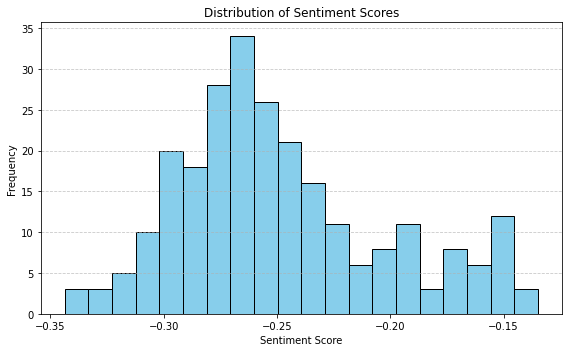

In [40]:

plt.figure(figsize=(8, 5))
plt.hist(stock_data['sentiment_impact'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Create Scatter Plots for Sentiment Impact vs. Stock Price Changes:

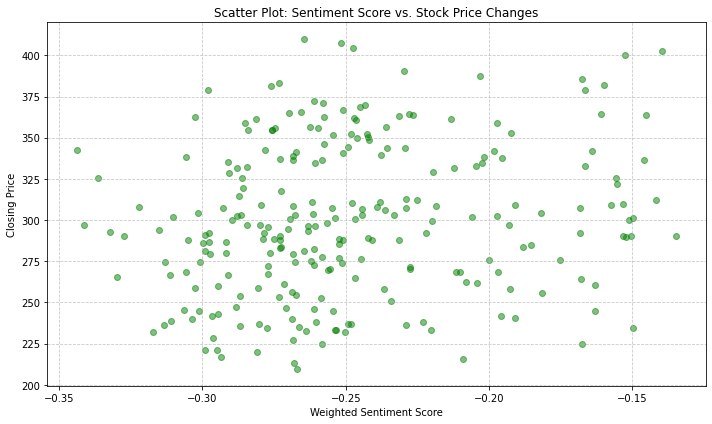

In [41]:
plt.figure(figsize=(10, 6))
plt.scatter(stock_data['sentiment_impact'], stock_data['Close'], alpha=0.5, color='green')
plt.title('Scatter Plot: Sentiment Score vs. Stock Price Changes')
plt.xlabel('Weighted Sentiment Score')
plt.ylabel('Closing Price')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### The above graph does not make a sense to me

## Calculating the Corelation betweeen Stock prices and Sentiment Scores

In [42]:
# Calculate the correlation coefficient between stock prices (e.g., 'Close') and sentiment scores (e.g., 'sentiment_impact')
correlation = stock_data['Close'].corr(stock_data['sentiment_impact'])

# Print the correlation coefficient
print(f"Correlation between Stock Prices and Sentiment Scores: {correlation:.2f}")

Correlation between Stock Prices and Sentiment Scores: 0.18


## Create Scatter Plots for WeightedSentimentScore vs. Stock Price Changes:

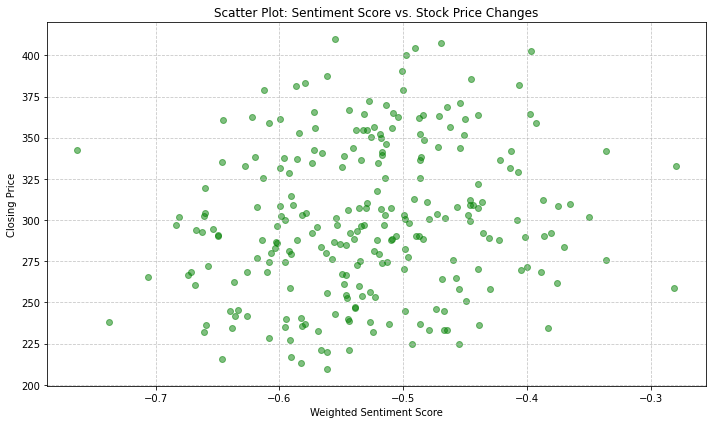

In [43]:
plt.figure(figsize=(10, 6))
plt.scatter(stock_data['WeightedSentimentScore'], stock_data['Close'], alpha=0.5, color='green')
plt.title('Scatter Plot: Sentiment Score vs. Stock Price Changes')
plt.xlabel('Weighted Sentiment Score')
plt.ylabel('Closing Price')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [44]:
# Calculate the correlation coefficient between stock prices (e.g., 'Close') and sentiment scores (e.g., 'sentiment_impact')
correlation = stock_data['Close'].corr(stock_data['WeightedSentimentScore'])

# Print the correlation coefficient
print(f"Correlation between Stock Prices and Sentiment Scores: {correlation:.2f}")

Correlation between Stock Prices and Sentiment Scores: 0.16


In [45]:
stock_data.tail(20)

,Date,Open,High,Low,Close,Adj Close,Volume,WeightedSentimentScore,sentiment_impact
232,2022-09-01,272.579987,277.579987,266.149994,277.160004,277.160004,54287000,-0.617775,-0.252509
233,2022-09-02,281.070007,282.350006,269.079987,270.209991,270.209991,50890100,-0.439673,-0.255457
234,2022-09-06,272.679993,275.989990,265.739990,274.420013,274.420013,55860000,-0.512620,-0.267824
235,2022-09-07,273.100006,283.839996,272.269989,283.700012,283.700012,50028900,-0.566395,-0.272443
236,2022-09-08,281.299988,289.500000,279.760010,289.260010,289.260010,53713100,-0.430196,-0.242338
237,2022-09-09,291.670013,299.850006,291.250000,299.679993,299.679993,54338100,-0.445640,-0.219731
238,2022-09-12,300.720001,305.489990,300.399994,304.420013,304.420013,48674600,-0.578827,-0.182024
239,2022-09-13,292.899994,297.399994,290.399994,292.130005,292.130005,68229600,-0.542524,-0.278523
240,2022-09-14,292.239990,306.000000,291.640015,302.609985,302.609985,72628700,-0.598550,-0.288070
241,2022-09-15,301.829987,309.119995,300.720001,303.750000,303.750000,64795500,-0.472497,-0.261459


In [70]:
stock_data['Date_pd'] = pd.to_datetime(stock_data['Date'])
pivot_table['Date_pd'] = pd.to_datetime(pivot_table['Date'])


overview_data = stock_data.merge(pivot_table, on = "Date_pd")

overview_data.head()

,Date_x,Open,High,Low,Close,Adj Close,Volume,Date_pd,Date_y,NEGATIVE,POSITIVE
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,2021-09-30,2021-09-30,115,63
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,2021-10-01,2021-10-01,165,59
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,2021-10-04,2021-10-04,243,46
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,2021-10-05,2021-10-05,137,42
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,2021-10-06,2021-10-06,144,40


## Effect of negative and positive comments on the stock price

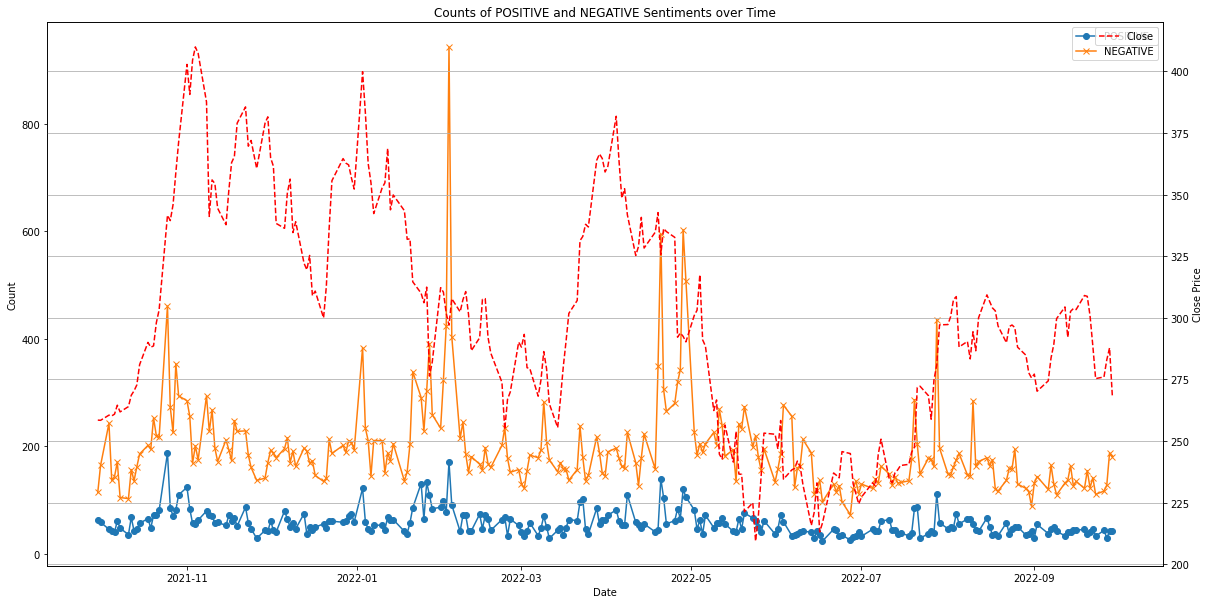

In [47]:

plt.figure(figsize=(20, 10))
plt.plot(overview_data['Date_pd'], overview_data['POSITIVE'], label='POSITIVE', marker='o')
plt.plot(overview_data['Date_pd'], overview_data['NEGATIVE'], label='NEGATIVE', marker='x')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Counts of POSITIVE and NEGATIVE Sentiments over Time')
plt.legend()

# Create a second y-axis for the 'Close' price
plt.twinx()
plt.plot(overview_data['Date_pd'], overview_data['Close'], label='Close', color='red', linestyle='--')
plt.ylabel('Close Price')
plt.legend(loc='upper right')

# Show the plot
plt.grid(True)
plt.show()




### One thing to observe in the above graph is that, right after a peak in the negative comments, their is a decline in the stock price over some time or atleast the price is stable for sometime.

### Another thing to note is that, when the negative comments are stable, then the stock price is also almost stable.

## Effect of Moving Average of Negative Comments and Close Price

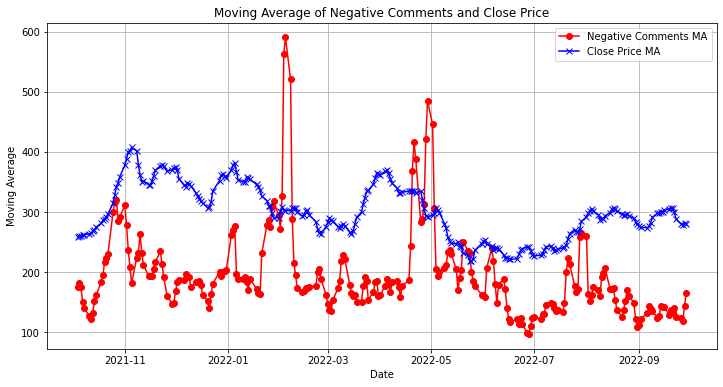

In [48]:
# Calculate the moving average of negative comments and close price
window_size = 3  # Adjust the window size as needed
overview_data['Negative_MA'] = overview_data['NEGATIVE'].rolling(window=window_size).mean()
overview_data['Close_MA'] = overview_data['Close'].rolling(window=window_size).mean()

# Create a line chart to visualize the trends
plt.figure(figsize=(12, 6))
plt.plot(overview_data['Date_pd'], overview_data['Negative_MA'], label='Negative Comments MA', marker='o', color='red')
plt.plot(overview_data['Date_pd'], overview_data['Close_MA'], label='Close Price MA', marker='x', color='blue')
plt.xlabel('Date')
plt.ylabel('Moving Average')
plt.title('Moving Average of Negative Comments and Close Price')
plt.legend()
plt.grid(True)

Correlation between POSITIVE and Close: 0.33
Correlation between NEGATIVE and Close: 0.20


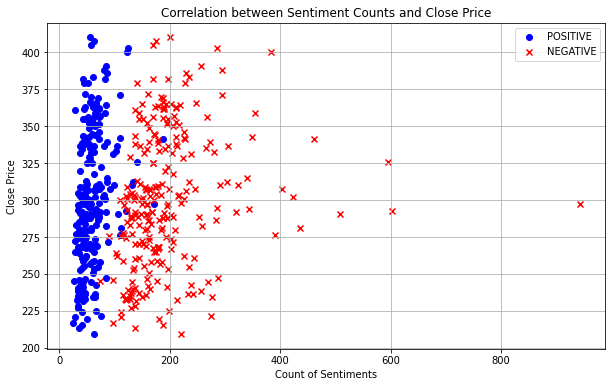

In [49]:
from scipy.stats import pearsonr
correlation_positive, _ = pearsonr(overview_data['POSITIVE'], overview_data['Close'])
correlation_negative, _ = pearsonr(overview_data['NEGATIVE'], overview_data['Close'])

# Print the correlation coefficients
print(f'Correlation between POSITIVE and Close: {correlation_positive:.2f}')
print(f'Correlation between NEGATIVE and Close: {correlation_negative:.2f}')

# Create a scatter plot to visualize the correlation
plt.figure(figsize=(10, 6))
plt.scatter(overview_data['POSITIVE'], overview_data['Close'], label='POSITIVE', marker='o', color='blue')
plt.scatter(overview_data['NEGATIVE'], overview_data['Close'], label='NEGATIVE', marker='x', color='red')
plt.xlabel('Count of Sentiments')
plt.ylabel('Close Price')
plt.title('Correlation between Sentiment Counts and Close Price')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()



## Plot of Sentiment impact over time

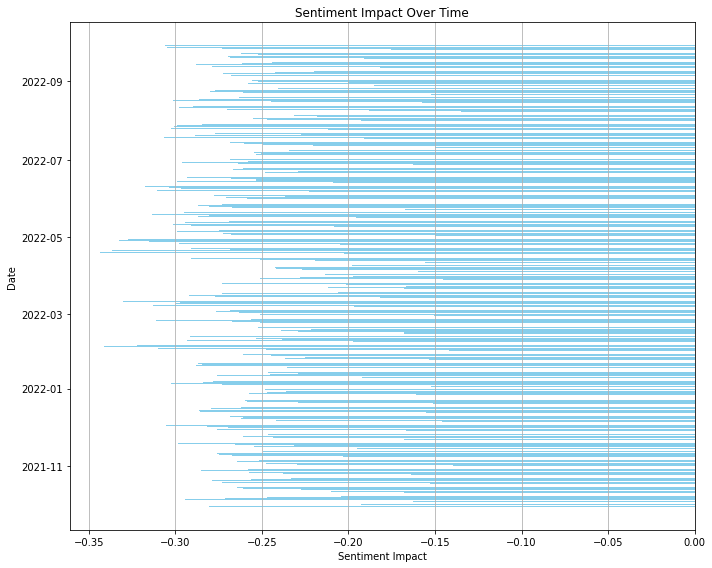

In [50]:

# Create a horizontal bar chart to visualize the 'sentiment_impact' scores
plt.figure(figsize=(10, 8))  # Increase the figure size
plt.barh(overview_data['Date_pd'], overview_data['sentiment_impact'], color='skyblue')
plt.xlabel('Sentiment Impact')
plt.ylabel('Date')
plt.title('Sentiment Impact Over Time')
plt.grid(axis='x')

# Use tight layout to ensure all dates are displayed
plt.tight_layout()

# Show the plot
plt.show()

## Building LSTM model, that takes into consideration the negative comments effect on stock price

In [51]:

# Define a function to prepare the data for LSTM
def prepare_data(data, window_size):
    # Separate scalers for each feature
    scaler_close = MinMaxScaler()
    scaler_negative = MinMaxScaler()
    
    data['Close_scaled'] = scaler_close.fit_transform(data['Close'].values.reshape(-1, 1))
    data['NEGATIVE_scaled'] = scaler_negative.fit_transform(data['NEGATIVE'].values.reshape(-1, 1))
    data['Sentiment_impact_scaled'] = scaler_close.fit_transform(data['sentiment_impact'].values.reshape(-1, 1))
    
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[['Close_scaled', 'NEGATIVE_scaled', 'sentiment_impact']].values[i:i+window_size])
        y.append(data['Close_scaled'].values[i+window_size])
    return np.array(X), np.array(y), scaler_close, scaler_negative  # Return the scalers too

# Set the window size for the LSTM
window_size = 2

# Prepare the data and get the scalers
X, y, scaler_close, scaler_negative = prepare_data(overview_data, window_size)

# Create a TimeSeriesSplit cross-validator
n_splits = 5  # You can adjust the number of splits
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize lists to store cross-validation results
cv_scores = []

# Initialize lists to store actual and predicted values for plotting
all_actual_values = []
all_predicted_values = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    desired_sequence_length = 7

    X_train = np.pad(X_train, ((0, 0), (desired_sequence_length - X_train.shape[1], 0), (0, 0)), mode='constant')
    X_test = np.pad(X_test, ((0, 0), (desired_sequence_length - X_test.shape[1], 0), (0, 0)), mode='constant')

    # Create and compile the LSTM model
    sequence_length = 7
    model = Sequential()
    model.add(LSTM(100, activation='relu', input_shape=(sequence_length, 3), kernel_regularizer=l2(0.01)))  # Add L2 regularization
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=2)

    # Evaluate the model
    test_loss = model.evaluate(X_test, y_test, verbose=0)
    cv_scores.append(test_loss)

    # Make predictions and inverse scaling for plotting
    y_pred = model.predict(X_test)
    y_pred = scaler_close.inverse_transform(y_pred)
    y_test = scaler_close.inverse_transform(y_test.reshape(-1, 1))

    # Store actual and predicted values for this fold
    all_actual_values.extend(y_test)
    all_predicted_values.extend(y_pred)





Epoch 1/100
2/2 - 1s - loss: 0.4991 - val_loss: 0.4261 - 1s/epoch - 519ms/step
Epoch 2/100
2/2 - 0s - loss: 0.4698 - val_loss: 0.3969 - 16ms/epoch - 8ms/step
Epoch 3/100
2/2 - 0s - loss: 0.4388 - val_loss: 0.3669 - 27ms/epoch - 14ms/step
Epoch 4/100
2/2 - 0s - loss: 0.4084 - val_loss: 0.3363 - 13ms/epoch - 7ms/step
Epoch 5/100
2/2 - 0s - loss: 0.3755 - val_loss: 0.3048 - 33ms/epoch - 16ms/step
Epoch 6/100
2/2 - 0s - loss: 0.3428 - val_loss: 0.2722 - 38ms/epoch - 19ms/step
Epoch 7/100
2/2 - 0s - loss: 0.3083 - val_loss: 0.2388 - 27ms/epoch - 14ms/step
Epoch 8/100
2/2 - 0s - loss: 0.2728 - val_loss: 0.2048 - 31ms/epoch - 15ms/step
Epoch 9/100
2/2 - 0s - loss: 0.2352 - val_loss: 0.1701 - 31ms/epoch - 16ms/step
Epoch 10/100
2/2 - 0s - loss: 0.1987 - val_loss: 0.1349 - 16ms/epoch - 8ms/step
Epoch 11/100
2/2 - 0s - loss: 0.1623 - val_loss: 0.1012 - 31ms/epoch - 16ms/step
Epoch 12/100
2/2 - 0s - loss: 0.1264 - val_loss: 0.0725 - 31ms/epoch - 16ms/step
Epoch 13/100
2/2 - 0s - loss: 0.0967 - va

## Plotting the graph

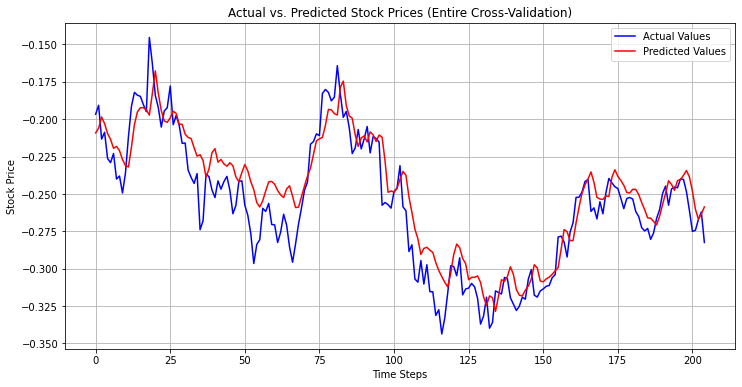

In [52]:
# Plot actual vs. predicted values for the entire cross-validation
plt.figure(figsize=(12, 6))
plt.plot(all_actual_values, label='Actual Values', color='blue')
plt.plot(all_predicted_values, label='Predicted Values', color='red')

# Add labels and legend
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()

# Show the plot
plt.title('Actual vs. Predicted Stock Prices (Entire Cross-Validation)')
plt.grid(True)
plt.show()

## Plot validation loss

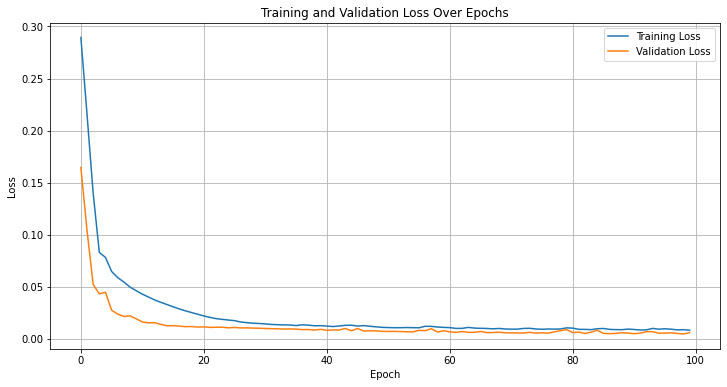

In [53]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

## Evaluation Metrics

In [54]:

# Calculate and print the cross-validation mean and standard deviation of the test loss
mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)
print(f'Cross-Validation Mean Test Loss: {mean_cv_score:.4f}')
print(f'Cross-Validation Test Loss Std. Deviation: {std_cv_score:.4f}')

# Calculate metrics for the entire cross-validation
rmse_test = np.sqrt(mean_squared_error(all_actual_values, all_predicted_values))
mse_test = mean_squared_error(all_actual_values, all_predicted_values)
mae_test = mean_absolute_error(all_actual_values, all_predicted_values)
r2_test = r2_score(all_actual_values, all_predicted_values)

# Print the testing metrics for the entire cross-validation
print("Testing Metrics (Entire Cross-Validation):")
print(f"Testing RMSE: {rmse_test:.4f}")
print(f"Testing MSE: {mse_test:.4f}")
print(f"Testing MAE: {mae_test:.4f}")
print(f"Testing R-squared: {r2_test:.4f}")

Cross-Validation Mean Test Loss: 0.0122
Cross-Validation Test Loss Std. Deviation: 0.0051
Testing Metrics (Entire Cross-Validation):
Testing RMSE: 0.0181
Testing MSE: 0.0003
Testing MAE: 0.0143
Testing R-squared: 0.8241


## Finding the Percentage of predictions within X percent

In [90]:

threshold_percentage = 10  

# Calculate the threshold value
threshold = threshold_percentage / 100.0

# Assuming y_true contains true values and y_pred contains predicted values
acceptable_predictions = 0

for true_val, pred_val in zip(all_actual_values, all_predicted_values):
    absolute_difference = abs(true_val - pred_val)
    if absolute_difference <= abs(threshold * true_val):
        acceptable_predictions += 1
        
# Calculate the percentage
percentage_within_threshold = (acceptable_predictions / len(all_actual_values)) * 100


print(f"Percentage of Predictions within ±{threshold_percentage}%: {percentage_within_threshold:.2f}%")


Percentage of Predictions within ±10%: 84.39%
